In [5]:
using Plots

function newton_fractal(f, df, maxiter=50, tol=1e-6, roots=[1.0, -1.0, im, -im])
    # generate a meshgrid over the complex plane
    x = range(-2, stop=2, length=800)
    y = range(-2, stop=2, length=800)
    z = [x + im*y' for y in y, x in x]
    
    # initialize arrays to store the iteration count and the root index for each pixel
    count = zeros(Int, size(z))
    root_index = zeros(Int, size(z))
    
    # apply Newton's method to each pixel
    for i in 1:maxiter
        z = z .- f(z) ./ df(z)
        for j in 1:length(roots)
            mask = (count .== 0) .& (abs(z - roots[j]) .< tol)
            count[mask] .= i
            root_index[mask] .= j
        end
    end
    
    # plot the fractal
    plot(z, count, seriestype=:heatmap, color=:rainbow, c=:blues, legend=:none)
end

# define the function whose roots we want to find
f(z) = z^3 - 1.0

# define the derivative of the function
df(z) = 3z^2

# generate the fractal
newton_fractal(f, df)

LoadError: MethodError: no method matching -(::Matrix{ComplexF64}, ::Float64)
For element-wise subtraction, use broadcasting with dot syntax: array .- scalar
[0mClosest candidates are:
[0m  -([91m::T[39m, ::T) where T<:Union{Float16, Float32, Float64} at float.jl:384
[0m  -([91m::AbstractGray{Bool}[39m, ::Number) at C:\Users\tkeeg\.julia\packages\ColorVectorSpace\QI5vM\src\ColorVectorSpace.jl:342
[0m  -([91m::AbstractGray[39m, ::Number) at C:\Users\tkeeg\.julia\packages\ColorVectorSpace\QI5vM\src\ColorVectorSpace.jl:340
[0m  ...

# Alt 2 method

  9.078675 seconds (1000.00 k allocations: 76.294 MiB, 0.22% gc time)


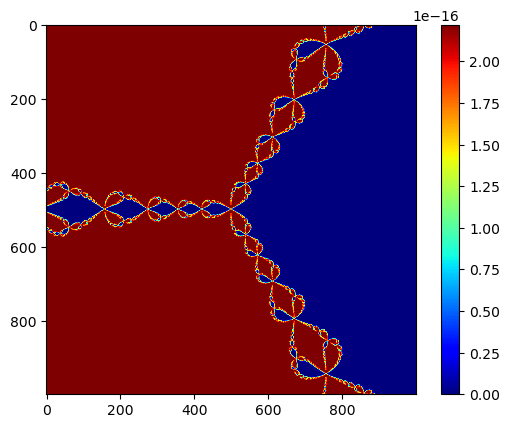

In [9]:
using PyPlot
function newton_fractal(f, f′, roots)
    x = range(-5, 5, length=1000)
    y = range(-5, 5, length=1000)

    image = zeros(length(y), length(x))

    @time begin
        for j = 1:length(y)
            for k = 1:length(x)
                z = x[k] + im * y[j]
                for i = 1:200
                    z = z - f(z) / f′(z)
                end
                val = maximum(abs.(f(z) .- roots))
                if val < 1e-6
                    image[j, k] = 1
                else
                    image[j, k] = log(val)
                end
            end
        end
    end
    imshow(image, cmap="jet")
    colorbar()
    show()
end

f(z) = z^3 - 1
f′(z) = 3z^2
roots = [1, -0.5 + im*sqrt(3)/2, -0.5 - im*sqrt(3)/2]

newton_fractal(f, f′, roots)

# q 1

In [ ]:
using LinearAlgebra
function newton_min(∇f::Function, Hessian::Function, 𝐱₀::Vector; max_nsteps::Int = 1000, abstol::Real = 1e-10)
     
    𝐱ₙ = 𝐱ₙ₊₁ = 𝐱₀
    
    history_𝐱 = [𝐱₀]
    
    for step = 1:max_nsteps
        
        𝐱ₙ₊₁ = 𝐱ₙ - Hessian(𝐱ₙ[1], 𝐱ₙ[2]) \ ∇f(𝐱ₙ[1], 𝐱ₙ[2])
        
        push!(history_𝐱, 𝐱ₙ₊₁)
        
        if norm(𝐱ₙ₊₁ - 𝐱ₙ) < abstol
           return hcat(history_𝐱...) 
        end
        
        𝐱ₙ = 𝐱ₙ₊₁ 
    end
    
    println("Maximum number of iterations is reached")
    
    return hcat(history_𝐱...)
end

∇f(x,y) = [2*x; 2*y]
Hessian(x,y) = [2 0; 0 2]
x₀ = [1.0, 1.0]

newton_min(∇f, Hessian, x₀)

# Q 3 attempts

In [46]:
import Pkg
Pkg.update("LinearAlgebra")

┌ Warning: could not download https://pkg.julialang.org/registries
│   exception = Could not resolve host: pkg.julialang.org while requesting https://pkg.julialang.org/registries
└ @ Pkg.Registry C:\workdir\usr\share\julia\stdlib\v1.8\Pkg\src\Registry\Registry.jl:68
    Updating registry at `C:\Users\tkeeg\.julia\registries\General.toml`
   Installed PlotUtils ─────────── v1.3.5
   Installed ConcurrentUtilities ─ v2.1.1
   Installed Compat ────────────── v4.6.1
   Installed OpenSSL ───────────── v1.4.0
   Installed JSON ──────────────── v0.21.4
   Installed TranscodingStreams ── v0.9.12
   Installed HTTP ──────────────── v1.8.0
   Installed Conda ─────────────── v1.8.0
   Installed Zstd_jll ──────────── v1.5.5+0
   Installed OrderedCollections ── v1.6.0
   Installed Parsers ───────────── v2.5.8
   Installed LogExpFunctions ───── v0.3.23
   Installed PrecompileTools ───── v1.0.2
   Installed Latexify ──────────── v0.15.20
   Installed ChangesOfVariables ── v0.1.6
   Installed ColorSchem

In [49]:
using LinearAlgebra

f(x) = x.^3 + 8.5x.^2 + 10.0x - 37.5
g(x) = x.^3 - 6.0x.^2 + 8.75x - 3.0

df(x) = [3x.^2 + 17x + 10; 3x.^2 - 12x + 8.75]
dg(x) = [3x.^2 + 17x + 10; 3x.^2 - 12x + 8.75]

function newton_system(f, g, df, dg, x0, tol=1e-8, maxiter=100)
    x = x0
    for i in 1:maxiter
        F = [f(x); g(x)]
        J = [df(x[1,:])'; dg(x[2,:])']
        if rank(J) < min(size(J))
            Q, R = qr(J)
            delta = -R \ (Q' * F)
        else
            delta = -J \ F
        end
        x += delta
        if norm(delta) < tol
            return x
        end
    end
    error("newton_system did not converge")
end

x0 = [1.0, 1.0]
x = newton_system(f, g, df, dg, x0)
println("The solution is x = $x")

LoadError: MethodError: no method matching -(::Vector{Float64}, ::Float64)
For element-wise subtraction, use broadcasting with dot syntax: array .- scalar
[0mClosest candidates are:
[0m  -([91m::T[39m, ::T) where T<:Union{Float16, Float32, Float64} at float.jl:384
[0m  -([91m::AbstractGray{Bool}[39m, ::Number) at C:\Users\tkeeg\.julia\packages\ColorVectorSpace\QI5vM\src\ColorVectorSpace.jl:342
[0m  -([91m::AbstractGray[39m, ::Number) at C:\Users\tkeeg\.julia\packages\ColorVectorSpace\QI5vM\src\ColorVectorSpace.jl:340
[0m  ...

In [ ]:
f(x) = x.^3 .+ 8.5x.^2 .+ 10.0x .- 37.5
g(x) = x.^3 .- 6.0x.^2 .+ 8.75x .- 3.0

df(x) = 3x.^2 .+ 17x .+ 10
dg(x) = 3x.^2 .- 12x .+ 8.75

function newton_system(f, g, df, dg, x0, tol=1e-8, maxiter=100)
    x = x0
    for i in 1:maxiter
        F = [f(x), g(x)]
        J = [df(x) dg(x); df(x) dg(x)]
        delta = -inv(J) * F
        x += delta
        if norm(delta) < tol
            return x
        end
    end
    error("newton_system did not converge")
end
x0 = [1.0, 1.0]
x = newton_system(f, g, df, dg, x0)
println("The solution is x = $x")

In [ ]:
# Somewhat working
function f(z)
    a, b = z
    f = a^3 - 3*a*b^2 - 1
    g = 3*a^2*b - b^3
    return [f, g]
end

function df(z)
    a, b = z
    dfda = 3a^2 - 3b^2
    dfdb = -6a*b
    dgda = 6a*b
    dgdb = 3a^2 - 3b^2
    return [dfda dfdb; dgda dgdb]
end

function newton_system(f, df, x0, tol=1e-8, maxiter=1000)
    x = copy(x0)
    for i in 1:maxiter
        fx = f(x)
        if norm(fx) < tol
            return x
        end
        J = df(x)
        dx = -J \ fx
        x += dx
    end
    return x
end

x0 = [0.01, 0.01]
root = newton_system(f, df, x0)
println(root)